In [63]:
# Clear all variables
%reset -f

In [64]:
import numpy as np
from scipy.stats import truncnorm

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from torch.distributions import Normal
import nnwosd as wosd
import importlib
importlib.reload(wosd)

from pysfa import SFA

In [66]:
n_samples=200

# True weights and bias
b_true = 2
w_true = torch.tensor([.3])

# Generate output with Gaussian noise
noise_std_v = .5
noise_std_u = .4

noise_v = torch.from_numpy(np.random.normal(0, noise_std_v, size=(n_samples, 1)).astype(np.float32))
noise_u = torch.from_numpy(abs(np.random.normal(0, noise_std_u, size=(n_samples, 1)).astype(np.float32)))
#case 1: linear

# X = torch.from_numpy((np.random.uniform(0.01, 3, size=(n_samples, 1)).astype(np.float32)))

log_X = torch.from_numpy((np.random.uniform(-3, 3, size=(n_samples, 1)).astype(np.float32)))

# y =  (X ** w_true) * b_true * np.exp( noise_v - noise_u)  # y = 5x + 10 + N(0, 2) - HN(0, 0.5)
log_y = w_true * log_X + np.log(b_true) + (noise_v - noise_u)

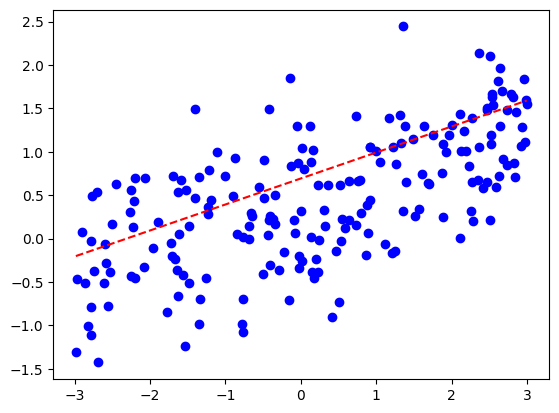

In [67]:
plt.scatter(log_X, log_y, color='blue', label='Data points')
sorted_indices = np.argsort(log_X[:, 0])  # Get the sorted indices of x values
log_X_sorted = log_X[sorted_indices]
log_y_sorted = log_y[sorted_indices]
# plt.plot(X_sorted, w_true * X_sorted + b_true, color='red', label='True regression line', linestyle='--')
plt.plot(log_X_sorted, w_true * log_X_sorted + np.log(b_true), color='red', label='True regression line', linestyle='--')


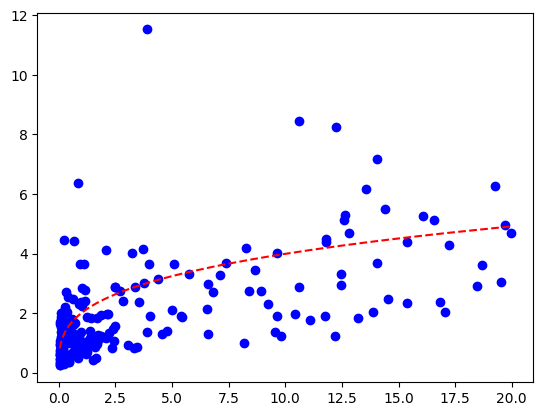

In [68]:
y = torch.exp(log_y)
X = torch.exp(log_X)
plt.scatter(X, y, color='blue', label='Data points')
sorted_indices = np.argsort(X[:, 0])  # Get the sorted indices of x values
X_sorted = X[sorted_indices]
y_sorted = y[sorted_indices]
# plt.plot(X_sorted, w_true * X_sorted + b_true, color='red', label='True regression line', linestyle='--')
plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')
# plt.plot(X_sorted, y_sorted, color='red', label='True regression line', linestyle='--')

# Fit SFM - code from Artem's book

In [69]:
from sfm_mle import estimate

# Import Data
y = log_y.numpy().flatten()  # Output
x1 = log_X.numpy().flatten()


true_vals = [b_true, w_true, noise_std_u, noise_std_v]
coefs, sterr, logMLE = estimate(y, x1, b_true, w_true, noise_std_u, noise_std_v)

# True values
true_vals = [b_true, w_true, noise_std_u, noise_std_v]

# Fitted values (convert as needed)
fitted_vals = [np.exp(coefs[0]), coefs[1], np.sqrt(coefs[2]), np.sqrt(coefs[3])]

# Print in two rows for comparison
print("True values:   ", true_vals)
print("Fitted values: ", fitted_vals)

True values:    [2, tensor([0.3000]), 0.4, 0.5]
Fitted values:  [2.0, 0.30000001192092896, 0.4, 0.5]


/home/zwei1/NNSFM/good_to_go/New_Sim_Dog_Cobbs/sfm_mle.py:26: RuntimeWarning: divide by zero encountered in log
  logDen = np.log(Den)
/home/zwei1/.conda/envs/d2l/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


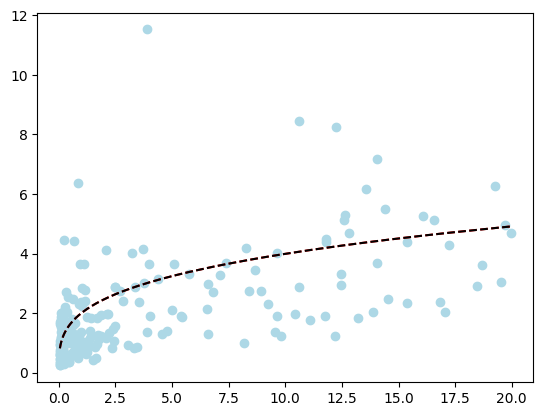

In [70]:
y = torch.exp(log_y)
plt.scatter(X, y, color='lightblue', label='Data points')
sorted_indices = np.argsort(X[:, 0])  # Get the sorted indices of x values
X_sorted = X[sorted_indices]
y_sorted = y[sorted_indices]
# plt.plot(X_sorted, w_true * X_sorted + b_true, color='red', label='True regression line', linestyle='--')
plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')
plt.plot(X_sorted, ((X_sorted**coefs[1])*np.exp(coefs[0])), color='black', label='True regression line', linestyle='--')
# plt.plot(X_sorted, y_sorted, color='red', label='True regression line', linestyle='--')

# Fit data by NN-Relu

In [71]:
# 2. Standardize input and output data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on the data and transform
X_standardized = torch.tensor(scaler_X.fit_transform(log_X), dtype=torch.float32)
y_standardized = torch.tensor(scaler_y.fit_transform(log_y), dtype=torch.float32)

In [72]:
# activation_fun = wosd.FlippedELU(alpha=0.1)
# activation_fun.forward(torch.tensor(0.2))

In [73]:
# Instantiate the model
input_size = 1  # Number of input features
hidden_sizes = [32,8]  # Concave-Relu Hidden layer sizes
output_size = 1 # 

activation_fun = nn.ReLU()
# activation_fun = nn.ELU()
# activation_fun = wosd.FlippedLeakRELU(alpha=0.8)
# activation_fun = wosd.FlippedELU(alpha=0.8)

model = wosd.MLP(input_size,hidden_sizes,output_size,activation_func=activation_fun)
# Instantiate the NLL loss function
nll_loss = wosd.GaussianNLLLoss(sigma_v=noise_std_v,sigma_u=noise_std_u)
# 5. Set up the optimizer (Adam)
optimizer = optim.Adam(list(model.parameters()) + [nll_loss.log_std_v, nll_loss.log_std_u] , lr=0.01)

In [74]:
model

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=8, bias=True)
  )
  (output): Linear(in_features=8, out_features=1, bias=True)
  (flipped_elu): ReLU()
)

In [75]:
# Variables to track the best loss and model parameters
best_loss = float('inf')  # Initialize best loss to infinity
best_model_state = None    # To save the model state

# List to store loss values for plotting
loss_values = []

# Train the deep learning model by minimizing the NLL loss
epochs = 1000
for epoch in range(epochs):
    model.train()  # Set the model to training mode

    # Forward pass: Predict outputs
    y_pred = model(X_standardized)

    # Compute NLL loss
    loss = nll_loss(y_pred, y_standardized)

    # Backward pass and optimization step
    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

    # Track loss values for plotting
    loss_values.append(loss.item())
    
    # with torch.no_grad():  # Turn off gradients temporarily
    #     for layer in model.layers:
    #         layer.weight.data.clamp_(min=0)  # Clamp weights to be >= 0
    #     model.output.weight.clamp_(min=0)  # Set min to 0 to make all weights >= 0
        
    # Check if the current loss is the best loss
    if loss.item() < best_loss:
        best_loss = loss.item()  # Update the best loss
        best_model_state = model.state_dict()  # Save the model state

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, '
              f'Log-Std(V): {nll_loss.log_std_v.item():.4f}, '
              f'Log-Std(U): {nll_loss.log_std_u.item():.4f}')

# After training, load the best model parameters
model.load_state_dict(best_model_state)

# Make predictions using the best model
with torch.no_grad():
    std_v_est = torch.exp(nll_loss.log_std_v).item()
    std_u_est = torch.exp(nll_loss.log_std_v).item()
    
    y_pred_best = model(X_standardized) 
    
    # Inverse transform predictions to original scale
    y_pred_best_original = scaler_y.inverse_transform(y_pred_best.numpy()) + np.sqrt(2/np.pi)*std_u_est   

Epoch [50/1000], Loss: 1.3052, Log-Std(V): -0.5075, Log-Std(U): -0.7306
Epoch [100/1000], Loss: 1.3375, Log-Std(V): -0.5303, Log-Std(U): -0.7535
Epoch [150/1000], Loss: 1.3340, Log-Std(V): -0.5320, Log-Std(U): -0.7551
Epoch [200/1000], Loss: 1.3322, Log-Std(V): -0.5344, Log-Std(U): -0.7576
Epoch [250/1000], Loss: 1.3305, Log-Std(V): -0.5365, Log-Std(U): -0.7596
Epoch [300/1000], Loss: 1.3289, Log-Std(V): -0.5381, Log-Std(U): -0.7612
Epoch [350/1000], Loss: 1.3270, Log-Std(V): -0.5393, Log-Std(U): -0.7625
Epoch [400/1000], Loss: 1.3283, Log-Std(V): -0.5406, Log-Std(U): -0.7637
Epoch [450/1000], Loss: 1.3242, Log-Std(V): -0.5417, Log-Std(U): -0.7649
Epoch [500/1000], Loss: 1.3261, Log-Std(V): -0.5427, Log-Std(U): -0.7659
Epoch [550/1000], Loss: 1.3234, Log-Std(V): -0.5439, Log-Std(U): -0.7671
Epoch [600/1000], Loss: 1.3260, Log-Std(V): -0.5445, Log-Std(U): -0.7676
Epoch [650/1000], Loss: 1.3234, Log-Std(V): -0.5451, Log-Std(U): -0.7682
Epoch [700/1000], Loss: 1.3201, Log-Std(V): -0.5455,

In [76]:
torch.exp(nll_loss.log_std_v).item()*scaler_y.scale_,torch.exp(nll_loss.log_std_u).item()*scaler_y.scale_

(array([0.43734362]), array([0.3498749]))

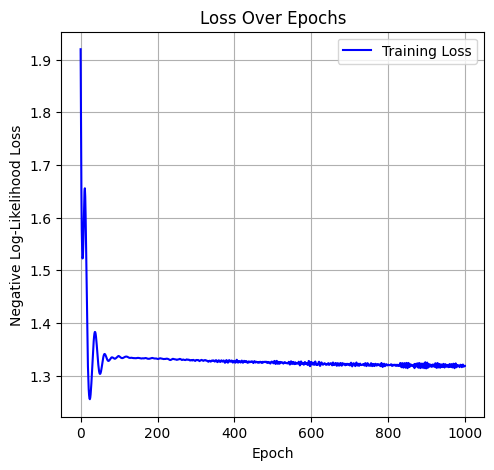

In [77]:
# 2. Plotting the loss and fitted curve
# Plotting the loss over epochs
plt.figure(figsize=(12, 5))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.grid()
plt.legend()

# plot in log scale

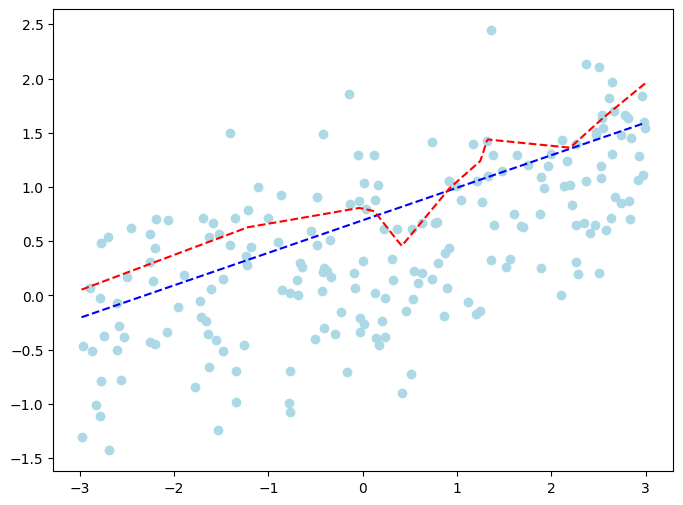

In [78]:
# Step 7: Plot the original data points and the fitted values
plt.figure(figsize=(8, 6))

# Sort the x values and corresponding predictions for a smooth line plot
sorted_indices = np.argsort(log_X[:, 0])  # Get the sorted indices of x values
log_X_sorted = log_X[sorted_indices]

y_pred_mean_sorted = y_pred_best_original[sorted_indices] 

# Scatter plot of the original data points
plt.scatter(log_X, log_y, color='lightblue', label='Data points')
plt.plot(log_X_sorted, w_true * log_X_sorted + np.log(b_true), color='blue', label='True regression line', linestyle='--')
plt.plot(log_X_sorted, y_pred_best_original[sorted_indices] , color='red', label='True regression line', linestyle='--')


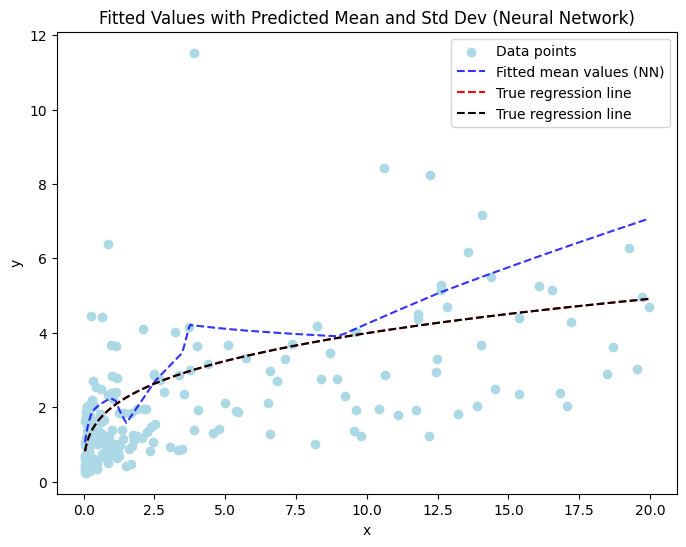

In [79]:
# Step 7: Plot the original data points and the fitted values
plt.figure(figsize=(8, 6))

# Sort the x values and corresponding predictions for a smooth line plot
sorted_indices = np.argsort(log_X[:, 0])  # Get the sorted indices of x values
log_X_sorted = log_X[sorted_indices]

# sigma_u_est = torch.exp(nll_loss.log_std_u).detach().numpy()*scaler_y.scale_
y_pred_mean_sorted = y_pred_best_original[sorted_indices] 

# Scatter plot of the original data points
plt.scatter(X, y, color='lightblue', label='Data points')

# Plot the fitted mean values (sorted for smoothness)
plt.plot(X_sorted, np.exp(y_pred_mean_sorted), color='blue', label='Fitted mean values (NN)', linestyle='--',alpha=0.8)
# plt.plot(X_sorted, np.exp(y_pred_mean_sorted)*correction_constant, color='darkblue', label='Fitted mean values (NN) with correction', linestyle='--',alpha=0.8)

plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')

plt.plot(X_sorted, ((X_sorted**coefs[1])*np.exp(coefs[0])), color='black', label='True regression line', linestyle='--')

# Plot the true regression line for reference
# plt.plot(x_sorted, true_slope * np.exp(x_sorted) + true_intercept, color='red', label='True regression line', linestyle='--')
# y = X @ w_true + b_true + torch.randn(N) * sigma_true # Adding noise
# plt.plot(X_sorted, (w_true * np.exp(-X_sorted) + b_true), color='black', label='True regression line')
# plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')

# y_sfm_mean_sorted = res.get_beta()[0]+res.get_beta()[1]*X_sorted
# plt.plot(X_sorted, np.exp(y_sfm_mean_sorted), color='green', label='Fitted mean values (SFM)', linestyle='--', alpha=0.8)


# Add labels and legend
plt.title('Fitted Values with Predicted Mean and Std Dev (Neural Network)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

In [80]:
#find residuals
y_original = scaler_y.inverse_transform(y_standardized.numpy())

# Residuals = observed - predicted
residuals = y_original.flatten() - y_pred_best_original.flatten()
correction_constant= np.mean(np.exp(residuals))
# y_pred_corrected = y_pred_best_original.flatten() * correction_constant

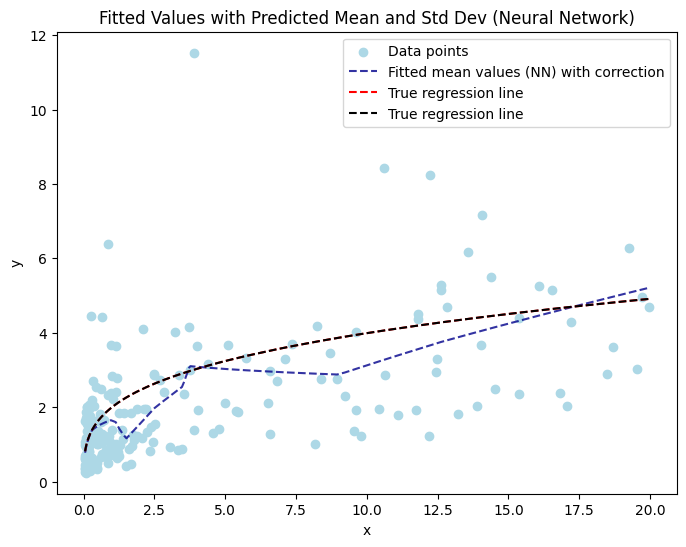

In [81]:
# Step 7: Plot the original data points and the fitted values
plt.figure(figsize=(8, 6))

# Sort the x values and corresponding predictions for a smooth line plot
sorted_indices = np.argsort(X[:, 0])  # Get the sorted indices of x values
X_sorted = X[sorted_indices]

# sigma_u_est = torch.exp(nll_loss.log_std_u).detach().numpy()*scaler_y.scale_
y_pred_mean_sorted = y_pred_best_original[sorted_indices] 

# Scatter plot of the original data points
plt.scatter(X, y, color='lightblue', label='Data points')

# Plot the fitted mean values (sorted for smoothness)
# plt.plot(X_sorted, np.exp(y_pred_mean_sorted), color='blue', label='Fitted mean values (NN)', linestyle='--',alpha=0.8)
plt.plot(X_sorted, np.exp(y_pred_mean_sorted)*correction_constant, color='darkblue', label='Fitted mean values (NN) with correction', linestyle='--',alpha=0.8)

plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')

plt.plot(X_sorted, ((X_sorted**coefs[1])*np.exp(coefs[0])), color='black', label='True regression line', linestyle='--')

# Plot the true regression line for reference
# plt.plot(x_sorted, true_slope * np.exp(x_sorted) + true_intercept, color='red', label='True regression line', linestyle='--')
# y = X @ w_true + b_true + torch.randn(N) * sigma_true # Adding noise
# plt.plot(X_sorted, (w_true * np.exp(-X_sorted) + b_true), color='black', label='True regression line')
# plt.plot(X_sorted, ((X_sorted**w_true)*b_true), color='red', label='True regression line', linestyle='--')

# y_sfm_mean_sorted = res.get_beta()[0]+res.get_beta()[1]*X_sorted
# plt.plot(X_sorted, np.exp(y_sfm_mean_sorted), color='green', label='Fitted mean values (SFM)', linestyle='--', alpha=0.8)


# Add labels and legend
plt.title('Fitted Values with Predicted Mean and Std Dev (Neural Network)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

# Fit four differnt activation functions :
    - ReLU, ELU, FlippedReLU, FlippedELU 
    - Apply weight constraints (clamping to ≥0) only for the self-defined activations (FlippedReLU and FlippedELU).


In [82]:
# activation_fun = nn.ReLU()
# activation_fun = nn.ELU()
# activation_fun = wosd.FlippedLeakRELU(alpha=0.8)
# activation_fun = wosd.FlippedELU(alpha=0.8)

activations = {
    "ReLU": nn.ReLU(),
    "ELU": nn.ELU(),
    "FlippedReLU": wosd.FlippedLeakRELU(alpha=0.8),
    "FlippedELU": wosd.FlippedELU(alpha=0.8)
}

# Which activations need weight clamping
clamp_activations = ["FlippedReLU", "FlippedELU"]

fitted_models = {}

for name, activation_fun in activations.items():
    print(f"\nTraining model with {name} activation...")

    # Instantiate model and loss
    model = wosd.MLP(input_size, hidden_sizes, output_size, activation_func=activation_fun)
    nll_loss = wosd.GaussianNLLLoss(sigma_v=noise_std_v, sigma_u=noise_std_u)
    optimizer = optim.Adam(list(model.parameters()) + [nll_loss.log_std_v, nll_loss.log_std_u], lr=0.01)

    best_loss = float('inf')
    best_model_state = None
    loss_values = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_standardized)
        loss = nll_loss(y_pred, y_standardized)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Apply weight constraints for self-defined activations
        if name in clamp_activations:
            with torch.no_grad():
                for layer in model.layers:
                    layer.weight.data.clamp_(min=0)
                model.output.weight.clamp_(min=0)

        loss_values.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)

    # Save everything in dictionary
    fitted_models[name] = {
        "model": model,
        "loss_history": loss_values,
        "std_v_est": torch.exp(nll_loss.log_std_v).item() * scaler_y.scale_,
        "std_u_est": torch.exp(nll_loss.log_std_u).item() * scaler_y.scale_
    }

print("Training completed for all activations.")



Training model with ReLU activation...

Training model with ELU activation...

Training model with FlippedReLU activation...

Training model with FlippedELU activation...
Training completed for all activations.


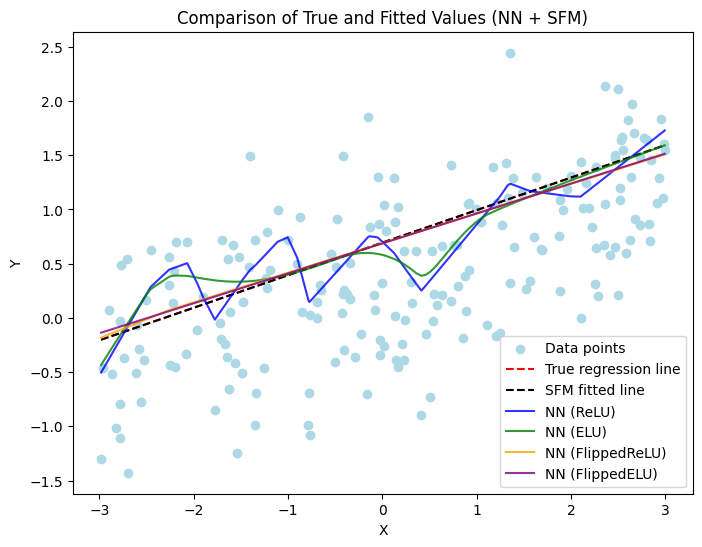

In [83]:
plt.figure(figsize=(8, 6))

sorted_indices = np.argsort(log_X[:, 0])  # Get the sorted indices of x values
log_X_sorted = log_X[sorted_indices]

y_pred_mean_sorted = y_pred_best_original[sorted_indices] 

# Scatter plot of the original data points
# plt.scatter(log_X, log_y, color='lightblue', label='Data points')
# plt.plot(log_X_sorted, w_true * log_X_sorted + np.log(b_true), color='blue', label='True regression line', linestyle='--')
# plt.plot(log_X_sorted, y_pred_best_original[sorted_indices] , color='red', label='True regression line', linestyle='--')


# Sort the x values and corresponding predictions for a smooth line plot
# sorted_indices = np.argsort(X[:, 0])  # Get the sorted indices of x values
# X_sorted = X[sorted_indices]

# Scatter plot of original data
plt.scatter(log_X, log_y, color='lightblue', label='Data points')
plt.plot(log_X_sorted, w_true * log_X_sorted + np.log(b_true), color='red', label='True regression line', linestyle='--')

# Plot SFM fitted line
plt.plot(log_X_sorted, (log_X_sorted*coefs[1])+(coefs[0]), color='black', label='SFM fitted line', linestyle='--')

# Plot fitted NN predictions for all activations
colors = ['blue', 'green', 'orange', 'purple']  # Different color for each activation
for i, (name, info) in enumerate(fitted_models.items()):
    model = info['model']
    with torch.no_grad():
        y_pred_std = model(X_standardized)
        # Add inefficiency correction if needed (same as you did before)
        std_u_est = info['std_u_est']
        y_pred_std = y_pred_std #+ np.sqrt(2/np.pi)*std_u_est
        # Inverse transform to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_std.numpy())+np.sqrt(2/np.pi)*std_u_est
        residuals = y_original.flatten() - y_pred_best_original.flatten()
        correction_constant= np.mean(np.exp(residuals))
    # Sort predictions according to X for smooth line
    y_pred_sorted = y_pred_original[np.argsort(X[:, 0])]
    plt.plot(log_X_sorted, y_pred_sorted, color=colors[i], linestyle='-', alpha=0.8, label=f'NN ({name})')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of True and Fitted Values (NN + SFM)')
plt.legend()
plt.show()


In [84]:
std_v_est,std_u_est

(0.5784381920571501, array([0.36266306]))

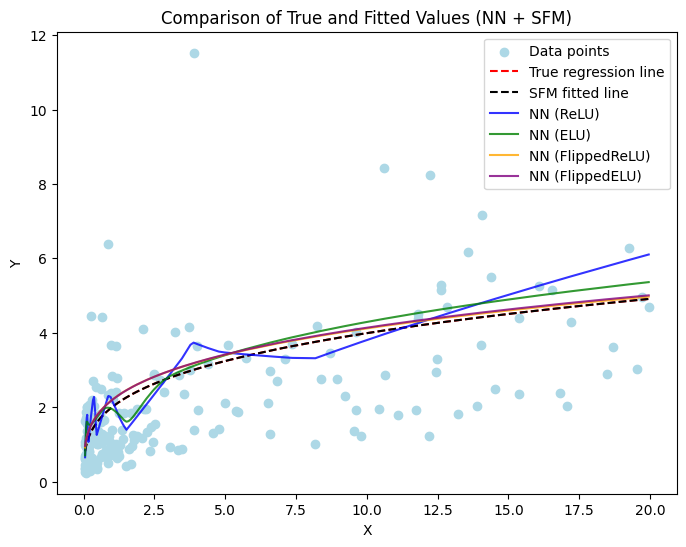

In [85]:
plt.figure(figsize=(8, 6))

# Sort the x values and corresponding predictions for a smooth line plot
sorted_indices = np.argsort(X[:, 0])  # Get the sorted indices of x values
X_sorted = X[sorted_indices]

# Scatter plot of original data
plt.scatter(X, y, color='lightblue', label='Data points')
plt.plot(X_sorted, (X_sorted**w_true)*b_true, color='red', label='True regression line', linestyle='--')

# Plot SFM fitted line
plt.plot(X_sorted, (X_sorted**coefs[1])*np.exp(coefs[0]), color='black', label='SFM fitted line', linestyle='--')

# Plot fitted NN predictions for all activations
colors = ['blue', 'green', 'orange', 'purple']  # Different color for each activation
for i, (name, info) in enumerate(fitted_models.items()):
    model = info['model']
    with torch.no_grad():
        y_pred_std = model(X_standardized)
        # Add inefficiency correction if needed (same as you did before)
        std_u_est = info['std_u_est']
        std_v_est = info['std_v_est']
        y_pred_std = y_pred_std + np.sqrt(2/np.pi)*std_u_est
        # Inverse transform to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_std.numpy())
        residuals = y_original.flatten() - y_pred_best_original.flatten()
        correction_constant= np.mean(np.exp(residuals))
    # Sort predictions according to X for smooth line
    y_pred_sorted = y_pred_original[np.argsort(X[:, 0])]
    # plt.plot(X_sorted, np.exp(y_pred_sorted)*correction_constant, color=colors[i], linestyle='-', alpha=0.8, label=f'NN ({name})')
    plt.plot(X_sorted, np.exp(y_pred_sorted)*np.exp((std_v_est**2+std_u_est**2)/2), color=colors[i], linestyle='-', alpha=0.8, label=f'NN ({name})')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of True and Fitted Values (NN + SFM)')
plt.legend()
plt.show()


In [86]:
y_tf = ((X**w_true)*b_true).numpy()
y_sfm_mean = ((X**coefs[1])*np.exp(coefs[0]))

RMSE_nn =  (np.mean(((np.exp(y_pred_best_original)-y_tf)/y_tf)**2))
RMSE_sfm = (np.mean(((y_sfm_mean.numpy()  -y_tf)/y_tf)**2))

RMSE_sfm,RMSE_nn

(0.0, 0.06283446)

In [87]:
y_tf = ((X**w_true)*b_true).numpy()
y_sfm_mean = ((X**coefs[1])*np.exp(coefs[0]))

RMSE_sfm = (np.mean(((y_sfm_mean.numpy()  -y_tf)/y_tf)**2))
BIAS_sfm = np.mean(np.abs(y_sfm_mean.numpy() -y_tf/y_tf))

sigma_v_sfm = np.sqrt(coefs[3])
sigma_u_sfm = np.sqrt(coefs[2])

bias_v_sfm = np.abs(sigma_v_sfm-noise_std_v)
bias_u_sfm = np.abs(sigma_u_sfm-noise_std_u)

#TE
vectorized_TE_fun = np.vectorize(wosd.TE_fun)

TE_true = vectorized_TE_fun(residuals=((np.log(y_tf)-(w_true * log_X + np.log(b_true)).numpy())),sig_v=noise_std_v,sig_u=noise_std_u)
TE_sfm = vectorized_TE_fun(residuals=(np.log(y_sfm_mean)-log_y.numpy()),sig_v=sigma_v_sfm,sig_u=sigma_u_sfm)

Bias_TE_sfm = np.mean(np.abs(TE_sfm-TE_true))

# RMSE for NN models
RMSE_nn = {}
BIAS_nn = {}
bias_v_nn = {}
bias_u_nn = {}
Bias_TE_nn = {}

for name, info in fitted_models.items():
    model = info['model']
    with torch.no_grad():
        y_pred_std = model(X_standardized)
        # Add inefficiency correction if needed
        std_u_est = info['std_u_est']
        std_v_est = info['std_v_est']
        y_pred_std = y_pred_std 
        # Inverse transform to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_std.numpy()) + np.sqrt(2/np.pi)*std_u_est
        residuals = y_original.flatten() - y_pred_best_original.flatten()
        correction_constant= np.mean(np.exp(residuals))
    
    # Calculate RMSE relative to true values
    rmse = np.sqrt(np.mean(((np.exp(y_pred_original)*np.exp((std_v_est**2+std_u_est**2)/2) - y_tf)/y_tf)**2))
    RMSE_nn[name] = rmse
    # Calculate absolute relative bias
    bias = np.mean(np.abs((np.exp(y_pred_original)*np.exp((std_v_est**2+std_u_est**2)/2) - y_tf)/y_tf))
    BIAS_nn[name] = bias
    
    sigma_v_nn=fitted_models[name]["std_v_est"]
    sigma_u_nn=fitted_models[name]["std_u_est"]
    
    bias_v_nn[name] = np.abs(sigma_v_nn - noise_std_v).item()
    bias_u_nn[name] = np.abs(sigma_u_nn - noise_std_u).item()
    
    # Calculate the bias of TE
    TE_nn = vectorized_TE_fun(residuals=(y_pred_original-log_y.numpy()),sig_v=sigma_v_nn,sig_u=sigma_u_nn)
    Bias_TE_nn[name] = np.mean(np.abs(TE_nn-TE_true)) 
    
    print(f"NN ({name}): RMSE = {rmse:.4f}, BIAS = {bias:.4f}, bias_v_nn = {bias_v_nn[name]:.4f}, bias_u_nn = {bias_u_nn[name]:.4f},TE_bias_nn = {Bias_TE_nn[name]:.4f}")


NN (ReLU): RMSE = 0.2745, BIAS = 0.2041, bias_v_nn = 0.0762, bias_u_nn = 0.0610,TE_bias_nn = 0.0619
NN (ELU): RMSE = 0.2375, BIAS = 0.1898, bias_v_nn = 0.0629, bias_u_nn = 0.0503,TE_bias_nn = 0.0603
NN (FlippedReLU): RMSE = 0.1759, BIAS = 0.1688, bias_v_nn = 0.0470, bias_u_nn = 0.0376,TE_bias_nn = 0.0580
NN (FlippedELU): RMSE = 0.1778, BIAS = 0.1708, bias_v_nn = 0.0467, bias_u_nn = 0.0373,TE_bias_nn = 0.0581


In [42]:
RMSE_sfm,BIAS_sfm,bias_v_sfm,bias_u_sfm

(0.0, 1.4302427, 0.0, 0.0)

In [43]:
torch.exp(nll_loss.log_std_v).item()*scaler_y.scale_,torch.exp(nll_loss.log_std_u).item()*scaler_y.scale_

(array([0.44341232]), array([0.35472985]))

In [44]:
(fitted_models['ReLU']["std_v_est"]),\
(fitted_models['ELU']["std_v_est"]) ,\
(fitted_models['FlippedReLU']["std_v_est"]) ,\
(fitted_models['FlippedELU']["std_v_est"]) 

(array([0.4263952]),
 array([0.43926096]),
 array([0.44377747]),
 array([0.44341232]))

In [45]:
np.exp(fitted_models['ReLU']["std_u_est"]) * scaler_y.scale_,\
np.exp(fitted_models['ELU']["std_u_est"]) * scaler_y.scale_,\
np.exp(fitted_models['FlippedReLU']["std_u_est"]) * scaler_y.scale_,\
np.exp(fitted_models['FlippedELU']["std_u_est"]) * scaler_y.scale_

(array([1.13915476]),
 array([1.15094018]),
 array([1.15510629]),
 array([1.1547689]))

In [46]:
fitted_models['ReLU']["std_v_est"],\
fitted_models['ELU']["std_v_est"],\
fitted_models['FlippedReLU']["std_v_est"],\
fitted_models['FlippedELU']["std_v_est"] 

(array([0.4263952]),
 array([0.43926096]),
 array([0.44377747]),
 array([0.44341232]))

In [47]:
fitted_models['ReLU']["std_u_est"],\
fitted_models['ELU']["std_u_est"],\
fitted_models['FlippedReLU']["std_u_est"],\
fitted_models['FlippedELU']["std_u_est"] 

(array([0.34111616]),
 array([0.35140877]),
 array([0.35502198]),
 array([0.35472985]))